In [1]:
import json, os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.neighbors import  NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import data

In [2]:
with open('Daten/Unternehmen_preprocessed.json', 'r', encoding='utf8') as data:
    desc = json.load(data)

In [3]:
print(desc[0]['explicit_lemmatization'])

significant operation company intend effect merger capital stock exchange asset acquisition stock purchase reorganization similar business combination business focus search business consumer product industry relate sector include consumer industry business health wellness commerce discretionary spending information technology sector related channel distribution company incorporate base Charlotte North Carolina


## Creating the dataset

In [4]:
all_mixed = []
for comp in desc:
    #print(comp)
    entry = {'txt': comp['explicit_lemmatization'], 'class': comp['sector']}
    all_mixed.append(entry)
len(all_mixed)

9822

# Klassifizierung

## Formulas

In [5]:
def classify(txt, v, vector):
    dummy = np.zeros(len(v.get_feature_names_out()))
    tmp_vectorizer = CountVectorizer(tokenizer = v.build_tokenizer())
    tmp_vector=tmp_vectorizer.fit_transform([txt])
    l = 0
    for f in tmp_vectorizer.vocabulary_:
        if f not in v.vocabulary_:
            continue

        index = v.vocabulary_[f]
        dummy[index] = tmp_vector[0, tmp_vectorizer.vocabulary_[f]] * v.idf_[index]
        l += dummy[index] ** 2
    l = np.sqrt(l)
    for i in range(vector.shape[1]):
        dummy[i] /= l
    #print(dummy)
    return dummy

In [6]:
def false_counter(dic, word):
    if word in dic:
        dic[word] += 1
    else:
        dic[word] = 1

## Create class to automate process

In [11]:
class data_instance:
    def __init__(self, dataset):
        self.X_data = [entry['txt'] for entry in dataset]
        self.y_data = [entry['class'] for entry in dataset]    
        
    def split_data(self, random_state, test_size):
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(self.X_data, self.y_data, test_size=test_size, random_state=random_state)
        #self.X_test = [self.X_test]
        
    def vectorize(self, df_value, max_df):
        if max_df:
            self.vectorizer = TfidfVectorizer(max_df = df_value)
            self.vector = self.vectorizer.fit_transform(self.X_train)
        else:
            self.vectorizer = TfidfVectorizer(min_df = df_value)
            self.vector = self.vectorizer.fit_transform(self.X_train)
        
    def neighbors(self, n_neighbors, init=False):
        self.neigh = KNeighborsClassifier(n_neighbors = n_neighbors).fit(self.vector, self.y_train)
        if init:
            return self.neigh
        else:
            return self.evaluate(self.neigh)
        
    def randomForest(self, n_estimators, init=False):
        self.forest = RandomForestClassifier(n_estimators = n_estimators).fit(self.vector, self.y_train)     
        if init:
            return self.forest
        else:
            return self.evaluate(self.forest)
        
    def centroid(self, init=False):
        self.centr = NearestCentroid().fit(self.vector, self.y_train)
        if init:
            return self.centr
        else:
            return self.evaluate(self.centr)
        
    def evaluate(self, classifier):
        n_correct = 0
        for i in range(len(self.X_test)):
            if self.y_test[i] == classifier.predict([classify(self.X_test[i], self.vectorizer, self.vector)])[0]:
                n_correct += 1
            #if i % 1500 == 0:
            #    print(i)
        score = n_correct / len(self.X_test)
        #print("calculated score =", score)
        return score

# Classification with the exact lemmatization dataset

### Create test/train data

In [12]:
test = data_instance(all_mixed)

Use random state to compare different results

In [13]:
test.split_data(123, 0.33)

In [14]:
test.vectorize(1.0, True)

### N_neighbors

In [15]:
# Test first for different max_accuracy
n_neighbors = {'neighbors': [], 'accuracy': []}
for neighbors in range(1, 7):
    n_neighbors['neighbors'].append(neighbors)
    acc = test.neighbors(neighbors)
    n_neighbors['accuracy'].append(acc)
    print(f"For {neighbors} neighbors, accuracy is {acc}.")

For 1 neighbors, accuracy is 0.824799506477483.
For 2 neighbors, accuracy is 0.8013571869216533.
For 3 neighbors, accuracy is 0.8340530536705737.
For 4 neighbors, accuracy is 0.8349784083898828.
For 5 neighbors, accuracy is 0.8550277606415793.
For 6 neighbors, accuracy is 0.8519432449105491.


In [16]:
print('Übersicht Klassifizierung n_neighbors')
pd.DataFrame(data=n_neighbors)

Übersicht Klassifizierung n_neighbors


,neighbors,accuracy
0,1,0.824800
1,2,0.801357
2,3,0.834053
3,4,0.834978
4,5,0.855028
5,6,0.851943


## Random Forest

In [17]:
randomForest = {'estimators': [], 'accuracy': []}
for estimators in range(1, 7):
    randomForest['estimators'].append(estimators)
    acc = test.randomForest(estimators)
    randomForest['accuracy'].append(acc)
    print(f"For {estimators} estimators, accuracy is {acc}.")

For 1 estimators, accuracy is 0.5530536705737199.
For 2 estimators, accuracy is 0.5743368291178285.
For 3 estimators, accuracy is 0.6224552745219001.
For 4 estimators, accuracy is 0.6804441702652684.
For 5 estimators, accuracy is 0.703269586674892.
For 6 estimators, accuracy is 0.7242442936458976.


In [18]:
print('Übersicht Klassifizierung Random Forest')
pd.DataFrame(data=randomForest, index=[i for i in range(1, 7)])

Übersicht Klassifizierung Random Forest


,estimators,accuracy
1,1,0.553054
2,2,0.574337
3,3,0.622455
4,4,0.680444
5,5,0.703270
6,6,0.724244


## Centroid

In [19]:
acc = test.centroid()
print(f"For nearest Centroid, accuracy is {acc}.")

For nearest Centroid, accuracy is 0.7819247378161629.


## Visualization of the results

### Confusion Matrix for the dataset with exact lemmatization

Confusion Matrix for the best possible results

In [20]:
gt = test.y_test

Create a predictor from the best result

In [21]:
predictor = test.neighbors(5, init=True)

In [22]:
pred = [predictor.predict([classify(test.X_test[i], test.vectorizer, test.vector)])[0] for i in range(0, len(test.X_test))]

In [24]:
secs = list({sec['sector'] for sec in desc})

In [25]:
cm = confusion_matrix(pred, gt, labels=secs)

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=secs)

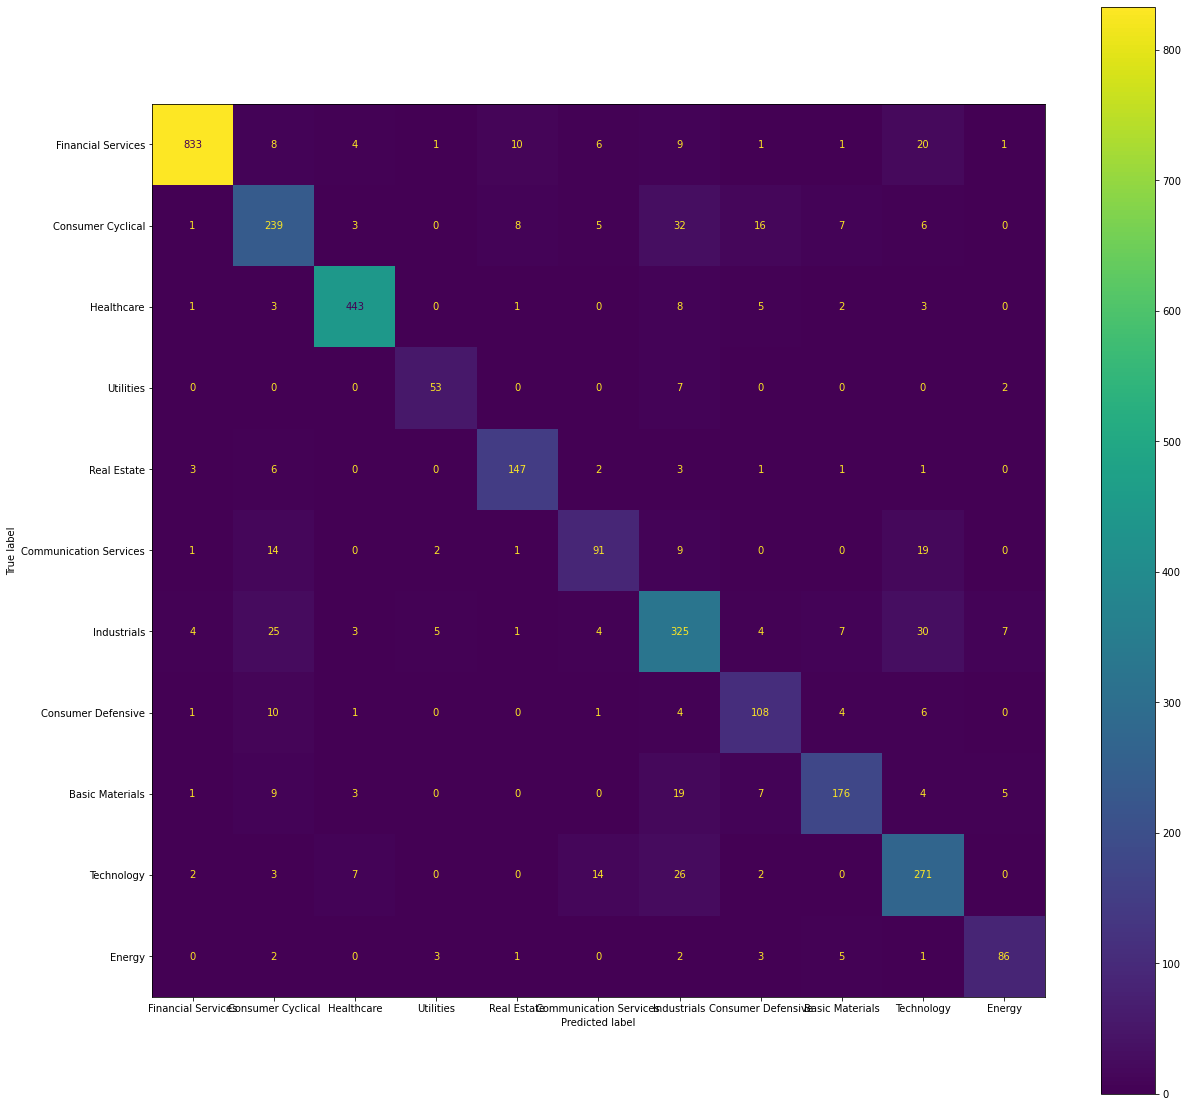

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax = ax)

# Classification with the less preprocessed dataset

## Creating dataset

In [28]:
all_mixed_rough = []
for comp in desc:
    #print(comp)
    entry = {'txt': comp['rough_lemmatization'], 'class': comp['sector']}
    all_mixed_rough.append(entry)
len(all_mixed_rough)

9822

### Create test_train data

In [29]:
rough_classification = data_instance(all_mixed_rough)

In [30]:
rough_classification.split_data(123, 0.33)

In [31]:
rough_classification.vectorize(1.0, True)

### N_neighbors

In [32]:
# Test first for different max_accuracy
n_neighbors = {'neighbors': [], 'accuracy': []}
for neighbors in range(1, 7):
    n_neighbors['neighbors'].append(neighbors)
    acc = rough_classification.neighbors(neighbors)
    n_neighbors['accuracy'].append(acc)
    print(f"For {neighbors} neighbors, accuracy is {acc}.")

For 1 neighbors, accuracy is 0.8177051202961135.
For 2 neighbors, accuracy is 0.7874768661320173.
For 3 neighbors, accuracy is 0.8297347316471314.
For 4 neighbors, accuracy is 0.8359037631091919.
For 5 neighbors, accuracy is 0.8479333744602098.
For 6 neighbors, accuracy is 0.8454657618753856.


In [33]:
print('Übersicht Klassifizierung n_neighbors')
pd.DataFrame(data=n_neighbors)

Übersicht Klassifizierung n_neighbors


,neighbors,accuracy
0,1,0.817705
1,2,0.787477
2,3,0.829735
3,4,0.835904
4,5,0.847933
5,6,0.845466


### Random Forest

In [34]:
randomForest = {'estimators': [], 'accuracy': []}
for estimators in range(1, 7):
    randomForest['estimators'].append(estimators)
    acc = rough_classification.randomForest(estimators)
    randomForest['accuracy'].append(acc)
    print(f"For {estimators} neighbors, accuracy is {acc}.")

For 1 neighbors, accuracy is 0.5814312152991981.
For 2 neighbors, accuracy is 0.5857495373226403.
For 3 neighbors, accuracy is 0.6394201110425664.
For 4 neighbors, accuracy is 0.6819864281307835.
For 5 neighbors, accuracy is 0.7045033929673041.
For 6 neighbors, accuracy is 0.716841455891425.


In [35]:
print('Übersicht Klassifizierung Random Forest')
pd.DataFrame(data=randomForest, index=[i for i in range(1, 7)])

Übersicht Klassifizierung Random Forest


,estimators,accuracy
1,1,0.581431
2,2,0.585750
3,3,0.639420
4,4,0.681986
5,5,0.704503
6,6,0.716841


### Centroid

In [36]:
acc = rough_classification.centroid()
print(f"For nearest Centroid, accuracy is {acc}.")

For nearest Centroid, accuracy is 0.7809993830968538.


## Visualization of the results

### Confustion matrix with the less preprocessed dataset

Confusion Matrix for the best possible results

In [37]:
gt = rough_classification.y_test

Create a predictor from the best result

In [38]:
predictor = rough_classification.neighbors(5, init=True)

In [39]:
pred = [predictor.predict([classify(rough_classification.X_test[i], rough_classification.vectorizer, rough_classification.vector)])[0] for i in range(0, len(rough_classification.X_test))]

In [40]:
secs = list({sec['sector'] for sec in desc})

In [42]:
cm = confusion_matrix(pred, gt, labels=secs)

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=secs)

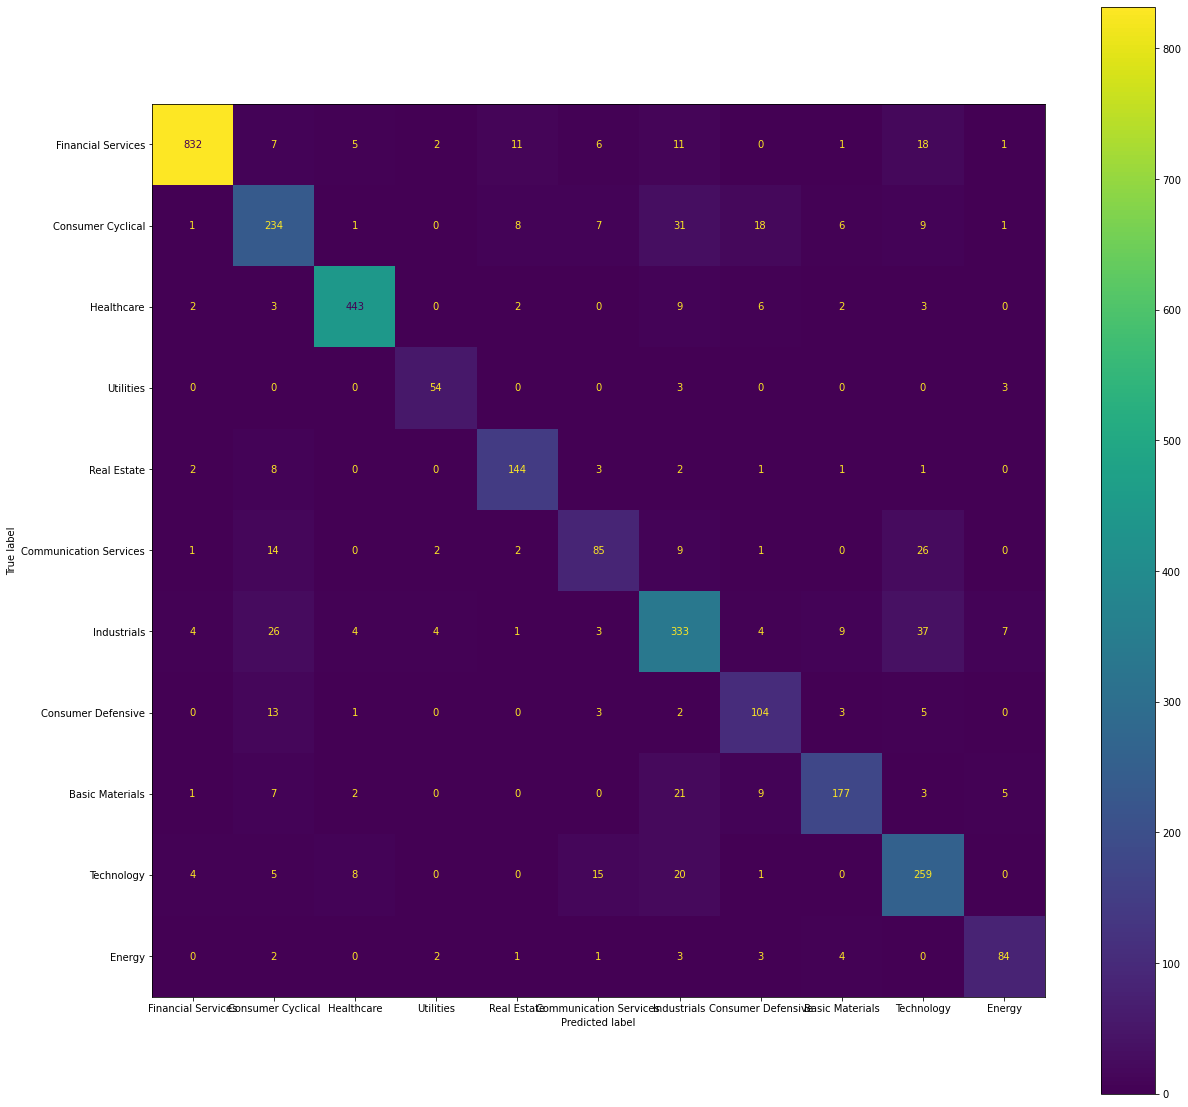

In [44]:
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax = ax)